In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
import onnx
import tf2onnx
import onnxruntime as ort

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

**Data Partition**

In [2]:
IMG_PATH = '../brain_tumor_dataset/'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < (0.2*IMG_NUM):
                shutil.copy(img, '../TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, '../TRAIN/' + CLASS.upper() + '/' + FILE_NAME)


**Data Preprocessing**

In [13]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=10
dataset_dir = '../TRAIN/'
test_dir  = '../TEST/'

def image_gen(height, width, batch_size):
    
    datagen = ImageDataGenerator(
        rescale=1./255.,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    
    test_ds = datagen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )

    return train_ds, test_ds

def augmented_data(height, width):

    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )
    
    return train_ds

train_ds, test_ds = image_gen(height, width, batch_size)

total_images = np.concatenate([train_ds.labels, test_ds.labels])
# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 152}


**Data Samples**

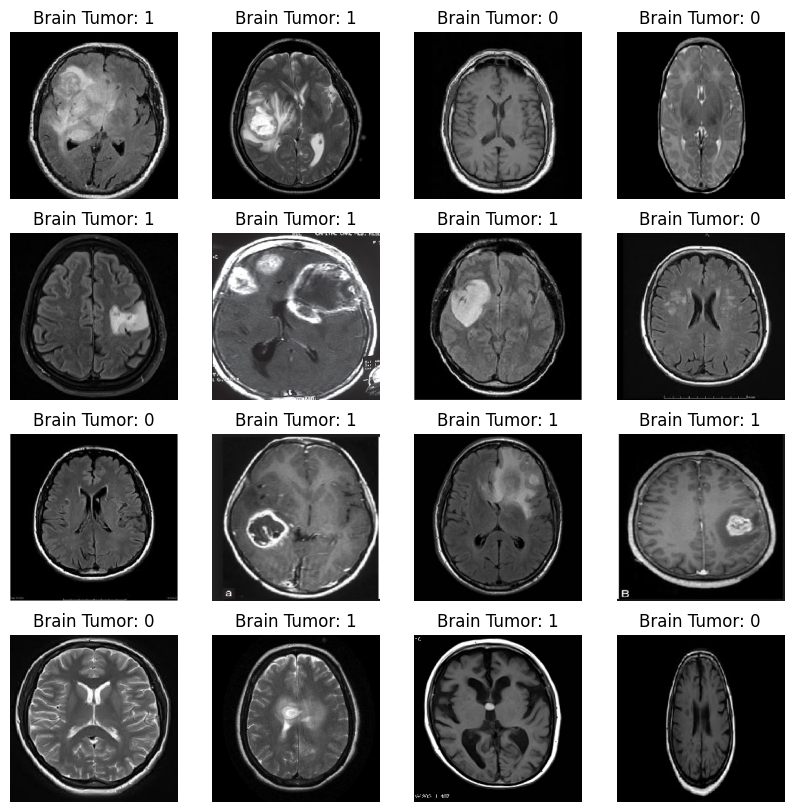

In [14]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
for k in range(16):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"Brain Tumor: {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

**Helper Function - Plots Accuracy and Loss Curves**

In [155]:
def plots(training_acc, testing_acc, training_loss, testing_loss, infer_time, onnx_infer_time):
  
  acc_categories = ['Training Accuracy', 'Testing Accuracy']
  acc_values = [training_acc, testing_acc]
  plt.figure(figsize=[12,6])

  plt.subplot(1, 3, 1)
  plt.bar(acc_categories, acc_values, width=0.2, color='green')
  plt.title('Training Vs Testing Accuracy')
  plt.ylabel('Accuracy')

  loss_categories = ['Training Loss', 'Testing Loss']
  loss_values = [training_loss, testing_loss]
  plt.subplot(1, 3, 2)
  plt.bar(loss_categories, loss_values, width=0.2)
  plt.title('Training Vs Testing Loss')
  plt.ylabel('Loss')

  infer_categories = ['Tensorflow Latency', 'ONNX Latency']
  infer_values = [infer_time, onnx_infer_time]
  plt.subplot(1, 3, 3)
  plt.bar(infer_categories, infer_values, width=0.2, color='red')
  plt.title('Tensorflow vs ONNX Latency')
  plt.ylabel('Latency (sec)')
  plt.show()
  

In [6]:
def plot_confusion_matrix(model, data):
    predictions = model.predict(data)
    labels = np.where(predictions>0.5,1,0)
    cm = confusion_matrix(data.labels, labels)
    plt.figure(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.xticks(rotation ='vertical')
    plt.show()

**ResNet50V2 - Deep Neural Network**

In [96]:
base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model.fit(train_ds, epochs=30, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [173]:
model = load_model('../models/resnet50v2_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {(inference_time)}")


5/5 [==============================] - 8s 1s/step - loss: 0.8659 - accuracy: 0.8000
Inference time: 7.95610237121582


In [98]:
output_path = "../models/resnet50v2_best.onnx"
spec = [(tf.TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)


Could not search for non-variable resources. Concrete function internal representation may have changed.


In [170]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 38
Total predictions: 50
Accuracy 0.76
Inference time: 0.8694


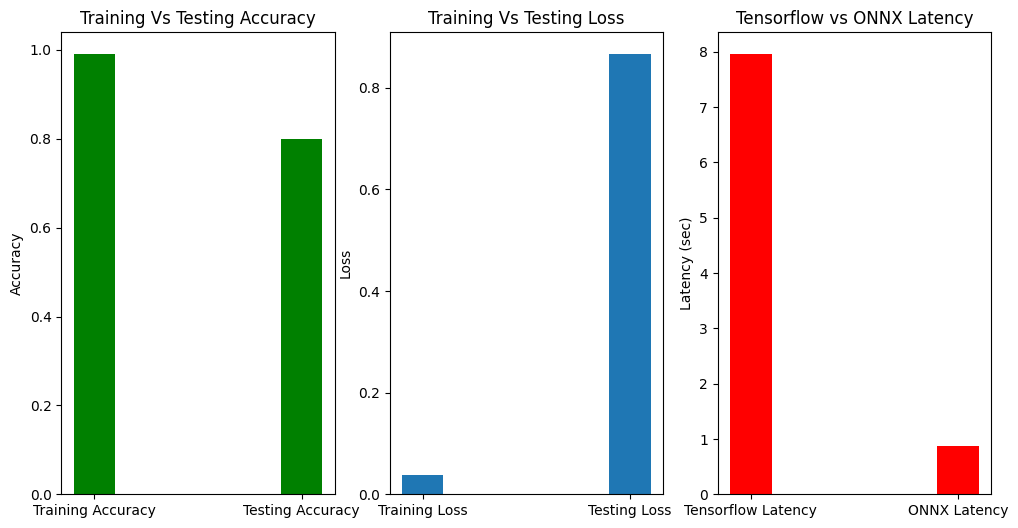

In [174]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

5/5 [==============================] - 10s 2s/step


<Figure size 800x800 with 0 Axes>

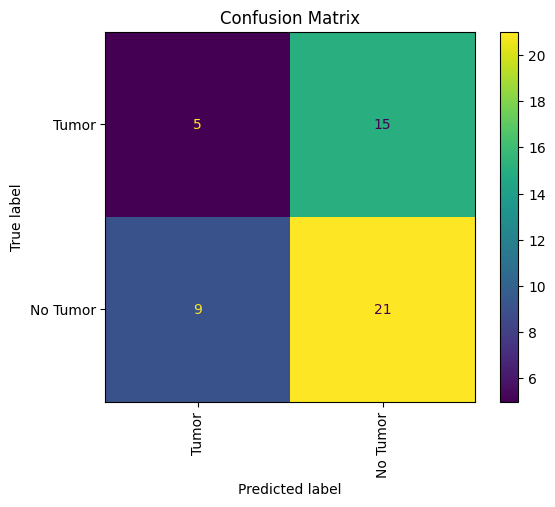

In [124]:
plot_confusion_matrix(model, test_ds)

**ResNet50V2 - Deep Neural Network with Augmented Data**

In [158]:
aug_train_ds = augmented_data(244, 244)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/resnet50v2aug_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=4, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model.fit(aug_train_ds, epochs=30, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9700
Epoch 1: accuracy improved from -inf to 0.97000, saving model to ../models\resnet50v2aug_best.h5
20/20 [==============================] - 24s 1s/step - loss: 0.0529 - accuracy: 0.9700 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9900
Epoch 2: accuracy improved from 0.97000 to 0.99000, saving model to ../models\resnet50v2aug_best.h5
20/20 [==============================] - 29s 1s/step - loss: 0.0491 - accuracy: 0.9900 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9650
Epoch 3: accuracy did not improve from 0.99000
20/20 [==============================] - 28s 1s/step - loss: 0.1092 - accuracy: 0.9650 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9800
Epoch 4: accuracy did not improve from 0.99000
20/20 [==========================

In [166]:
model = load_model('../models/resnet50v2aug_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = end_time-start_time
print(f"Inference time: {inference_time}")

5/5 [==============================] - 7s 1s/step - loss: 0.9733 - accuracy: 0.7600
Inference time: 7.07375955581665


In [160]:
output_path = "../models/resnet50v2aug_best.onnx"
spec = [(tf.TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [161]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 38
Total predictions: 50
Accuracy 0.76
Inference time: 0.8471


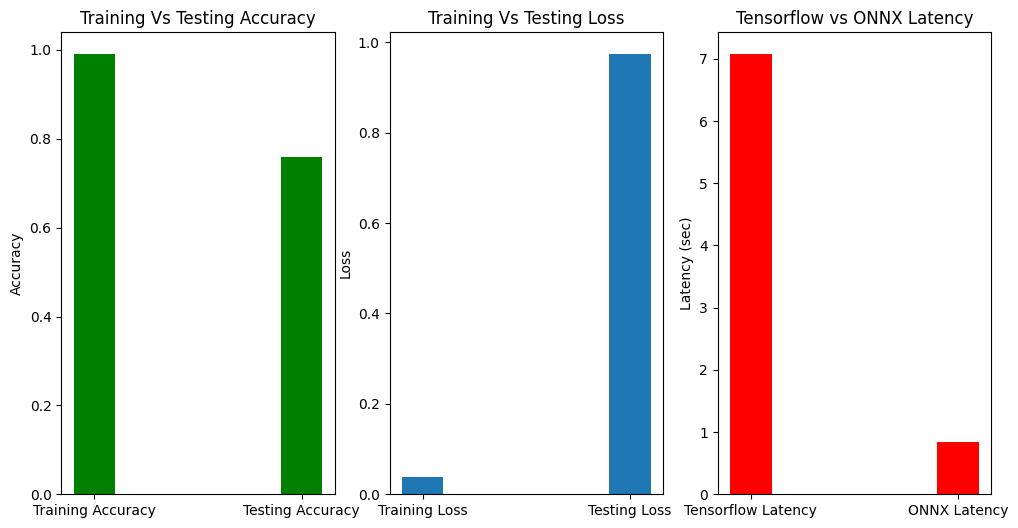

In [168]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

5/5 [==============================] - 6s 925ms/step


<Figure size 800x800 with 0 Axes>

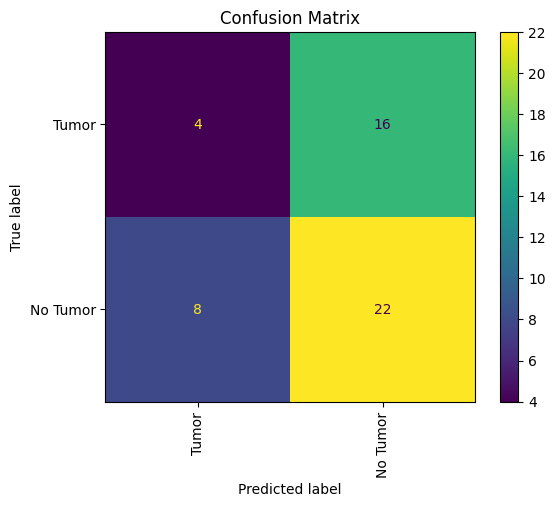

In [163]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network**

In [175]:
tf.keras.backend.clear_session()

#initializing new height and width for images
train_ds, test_ds = image_gen(224, 224, batch_size)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])
model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model.fit(train_ds, epochs=30, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.6300
Epoch 1: accuracy improved from -inf to 0.63000, 

In [176]:
model = load_model('../models/vgg19_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

5/5 [==============================] - 16s 3s/step - loss: 0.6357 - accuracy: 0.8400
Inference time: 16.454569578170776


In [178]:
output_path = "../models/vgg19_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [179]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 42
Total predictions: 50
Accuracy 0.84
Inference time: 0.8694


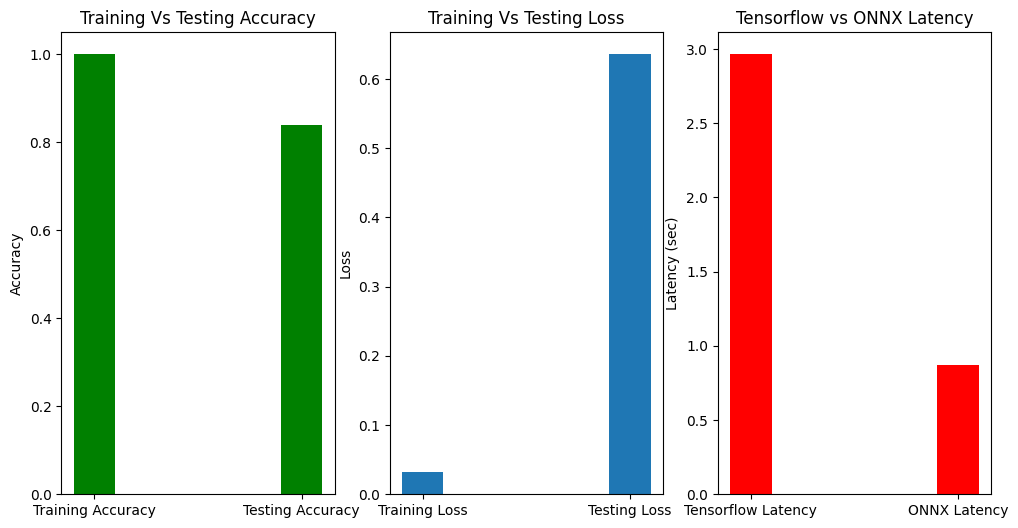

In [180]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

5/5 [==============================] - 16s 3s/step


<Figure size 800x800 with 0 Axes>

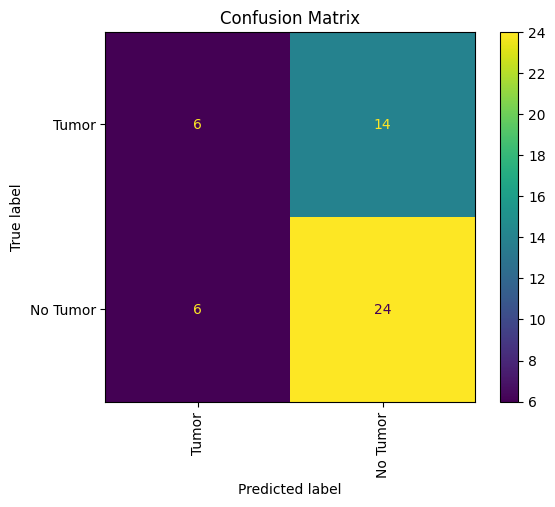

In [181]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network with Augmented Data**

In [182]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg19_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model.fit(aug_train_ds, epochs=15, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.


Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8550
Epoch 1: accuracy improved from -inf to 0.85500, saving model to ../models\vgg19_aug.h5
20/20 [==============================] - 72s 4s/step - loss: 0.3450 - accuracy: 0.8550 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8600
Epoch 2: accuracy improved from 0.85500 to 0.86000, saving model to ../models\vgg19_aug.h5
20/20 [==============================] - 76s 4s/step - loss: 0.3947 - accuracy: 0.8600 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.8950
Epoch 3: accuracy improved from 0.86000 to 0.89500, saving model to ../models\vgg19_aug.h5
20/20 [==============================] - 81s 4s/step - loss: 0.2626 - accuracy: 0.8950 - lr: 0.0010
Epoch 4/15
 4/20 [=====>........................] - ETA: 56s - loss: 0.1822 - accuracy: 0.9000 

KeyboardInterrupt: 

In [ ]:
model = load_model('../models/vgg19_aug.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

4/4 [==============================] - 15s 3s/step - loss: 0.5199 - accuracy: 0.7647
Inference time: 15.424119710922241


In [ ]:
output_path = "../models/vgg19_aug.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

In [ ]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

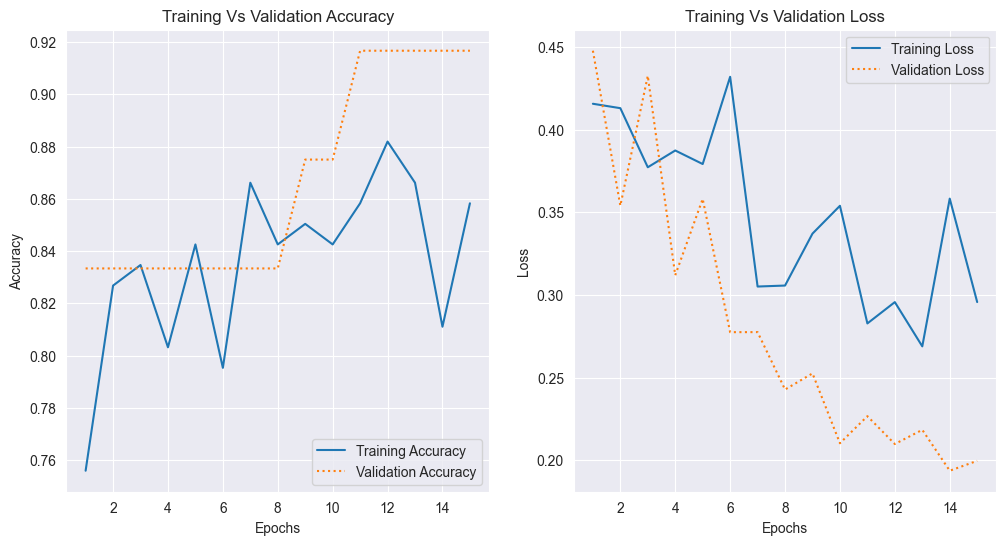

In [ ]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

4/4 [==============================] - 16s 3s/step


<Figure size 800x800 with 0 Axes>

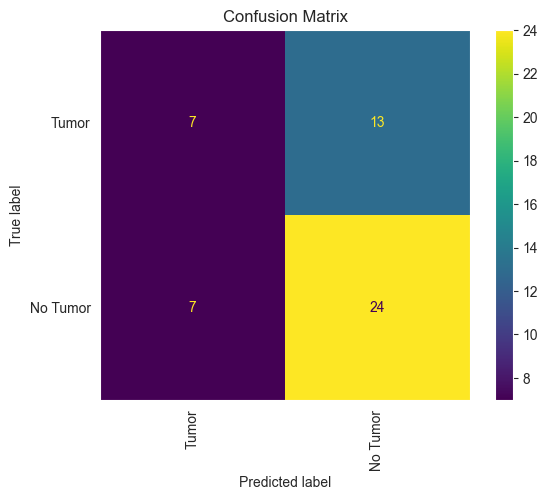

In [ ]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network**

In [71]:
tf.keras.backend.clear_session()

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=3)

callbacks_list = [checkpoint,early]

history = model.fit(train_ds,
           epochs=15,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

58889256/58889256 [==============================] - 15s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.6311
Epoch 1: accuracy improved from -inf to 0.63107, saving model to vgg16_best.h5
7/7 [==============================] -

In [72]:
model = load_model('../models/vgg16_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

4/4 [==============================] - 12s 3s/step - loss: 0.5443 - accuracy: 0.7255
Inference time: 12.41807508468628


In [ ]:
output_path = "../models/vgg16_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

In [ ]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

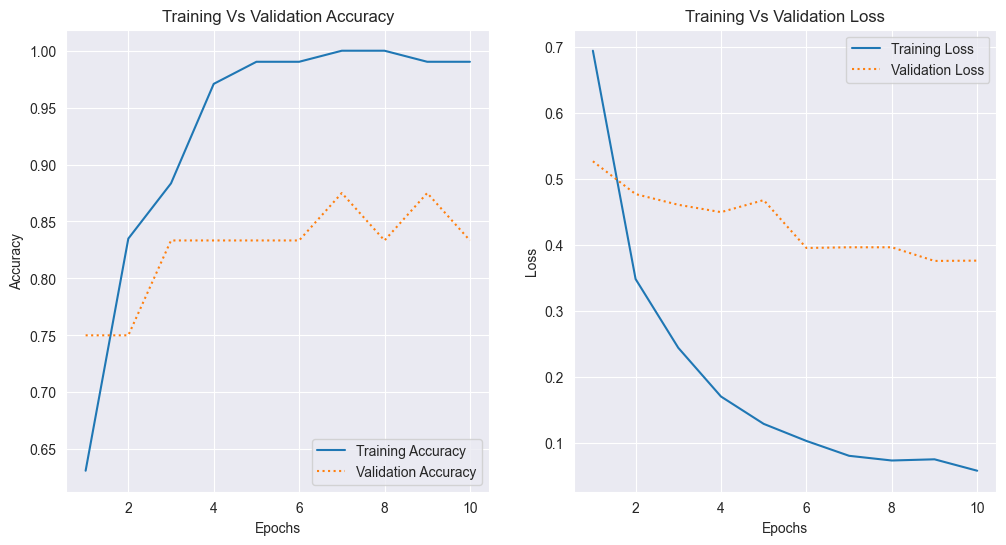

In [73]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

4/4 [==============================] - 12s 3s/step


<Figure size 800x800 with 0 Axes>

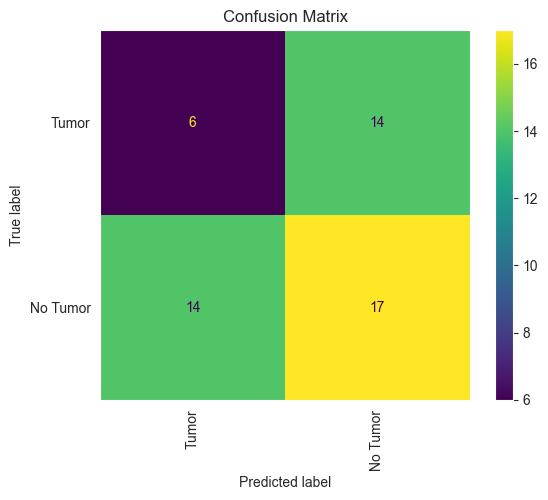

In [74]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network with Augmented Data**

In [75]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg16_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

historys = model.fit(aug_train_ds, epochs=15, callbacks=callbacks_list)

Found 127 images belonging to 2 classes.


Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8583
Epoch 1: accuracy improved from -inf to 0.85827, saving model to vgg16_aug.h5
8/8 [==============================] - 37s 5s/step - loss: 0.3910 - accuracy: 0.8583 - val_loss: 0.4110 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8976
Epoch 2: accuracy improved from 0.85827 to 0.89764, saving model to vgg16_aug.h5
8/8 [==============================] - 37s 5s/step - loss: 0.2991 - accuracy: 0.8976 - val_loss: 0.3591 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8583
Epoch 3: accuracy did not improve from 0.89764
8/8 [==============================] - 37s 5s/step - loss: 0.3378 - accuracy: 0.8583 - val_loss: 0.2761 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9134
Epoch 

In [76]:
model = load_model('../models/vgg16_aug.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

4/4 [==============================] - 12s 3s/step - loss: 0.4693 - accuracy: 0.8039
Inference time: 12.342668056488037


In [ ]:
output_path = "../models/vgg16_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

In [ ]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

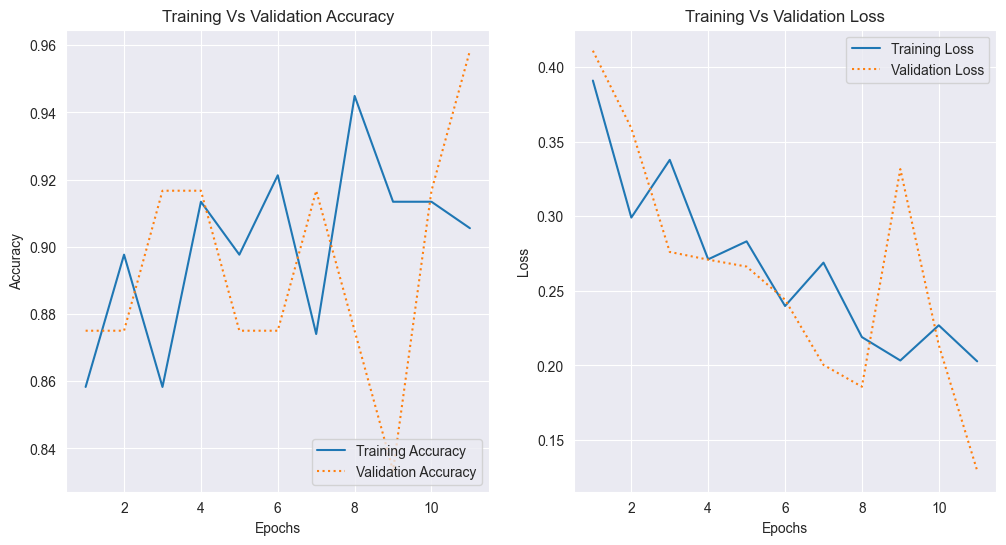

In [77]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

4/4 [==============================] - 13s 3s/step


<Figure size 800x800 with 0 Axes>

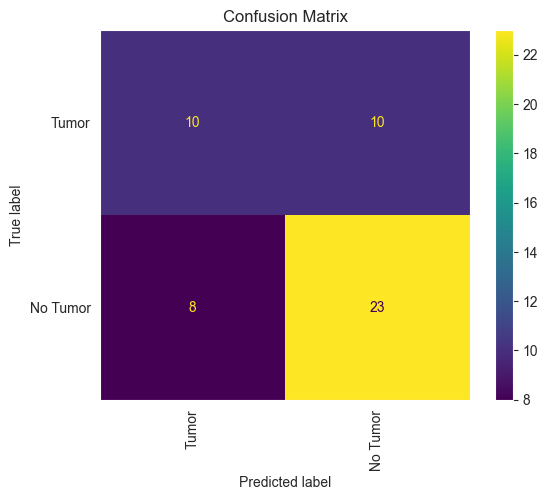

In [78]:
plot_confusion_matrix(model, test_ds)

**End of File**